In [1]:
#Python processing stuff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

#R stuff
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
''' Remove comment if clusrank needs to be downloaded
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('clusrank')
'''
ro.r('library(clusrank)')

#Constants
FILENAME = "ARPY5Data.xlsx" #filename
names = ["NSSCR/min","SCR","SCL",'TVSymp','EDASymp']

In [2]:
def formating(iarr,num,start=0):
    columns = iarr.columns
    unnamed_indices = [i for i, col in enumerate(columns) if "Unnamed" in str(col)]
    dfwa = []
    for i in range(len(unnamed_indices)):
        try:
            dfwa.append(iarr.iloc[:,unnamed_indices[i]:unnamed_indices[i+1]])
        except:
            dfwa.append(iarr.iloc[:,unnamed_indices[i]:])
    sessions = ["baseline 1", "llm", "baseline 2", "text"]
    baseline1 = []
    df1 = []
    baseline2 = []
    df2 = []
    for i in dfwa:
        indices = [i[i.iloc[:,0].str.lower() == keyword].index.tolist()[0] for keyword in sessions]
        indices.sort()
        arr = []
        for j in range(len(indices)):
            try:
                arr.append(pd.DataFrame(i.iloc[indices[j]+1:indices[j+1],1:]).reset_index(drop=True))
            except:
                arr.append(pd.DataFrame(i.iloc[indices[j]+1:,1:]).reset_index(drop=True))
        baseline1.append(arr[0])
        df1.append(arr[1])
        baseline2.append(arr[2])
        df2.append(arr[3])
    arrf = []
    arrf2 = []
    for i in range(len(df1)):
        df1[i] = (df1[i] - baseline1[i].iloc[df1[i].index % 5].reset_index(drop=True)).reset_index(drop=True)
        df2[i] = (df2[i] - baseline2[i].iloc[df2[i].index % 5].reset_index(drop=True)).reset_index(drop=True)
        dft1 = pd.DataFrame()
        dft2 = pd.DataFrame()
        for col in df1[i].columns:
            for j in range(5):
                dft1[f'{names[j]}'] = df1[i][col].iloc[j::5].reset_index(drop=True)
            arrf.append(dft1)
            dft1 = pd.DataFrame()
        for col in df2[i].columns:
            for j in range(5):
                dft2[f'{names[j]}'] = df2[i][col].iloc[j::5].reset_index(drop=True)
            arrf2.append(dft2)
            dft2 = pd.DataFrame()
    for i in arrf:
        i.dropna(inplace=True)
    for i in arrf2:
        i.dropna(inplace=True)
    cd = []
    for i, df in enumerate(arrf):
        cluster = np.full(len(df), i+start)
        df['cluster'] = cluster
        cd.append(df)
    cd2 = []
    for i, df in enumerate(arrf2):
        cluster = np.full(len(df), i+start)
        df['cluster'] = cluster
        cd2.append(df)
    cd3 = []
    if num == 1: #lr
        for i in range(len(cd)):     
            cd3.append(pd.concat([cd[i],cd2[i]],axis=1))
    else: #rl
        for i in range(len(cd)):
            cd3.append(pd.concat([cd2[i],cd[i]],axis=1))
    final_df = pd.concat(cd3, ignore_index=True).iloc[:,:-1]
    return final_df,max(len(arrf),len(arrf2))+start

In [3]:
dfw1 = pd.read_excel(FILENAME,sheet_name=0)
dfw2 = pd.read_excel(FILENAME,sheet_name=1)
dfwt1,start = formating(dfw1,1) #num=1 for LLM before text, num!=1 for text before LLM.
dfwt2, start = formating(dfw2,2,start)
dfwt3 = pd.concat([dfwt1,dfwt2],ignore_index=True)
dfwt3.head(10)

,NSSCR/min,SCR,SCL,TVSymp,EDASymp,cluster,NSSCR/min,SCR,SCL,TVSymp,EDASymp
0,-7.666667,2.390173,-4.824639,0.10149,0.124663,0.0,20,0.104819,-0.86202,0.25681,0.022049
1,-10.333333,-8.47584,9.513549,-0.017425,-0.000084,0.0,11.333333,-7.606761,8.12065,0.22896,0.020626
2,-10.0,-8.471693,9.510999,-0.017298,-0.000083,0.0,7,-21.001834,25.428191,0.011818,0.038783
3,-1.333333,9.985132,-13.802395,0.016085,0.051425,0.0,21,-17.061821,20.955866,0.173394,0.037883
4,-8.0,-0.524234,0.452549,0.008142,0.005565,1.0,-12.333333,-3.133057,4.020996,-0.17011,-0.009326
5,-10.666667,-1.098568,1.20068,-0.195544,-0.000645,1.0,-12.0,-3.129371,4.016228,-0.167969,-0.009325
6,-10.666667,-1.098972,1.20201,-0.195911,-0.000646,1.0,-12.0,-3.131214,4.020205,-0.168936,-0.009326
7,-10.333333,-1.098141,1.200477,-0.196641,-0.000646,1.0,-12.0,-3.119762,4.005055,-0.171219,-0.009325
8,-2,0.02021,-0.056999,0.0093,0.000265,2.0,-9.0,-0.0455,0.055939,-0.041538,-0.000312
9,-3,0.045754,-0.08824,0.092135,0.000582,2.0,-6.333333,0.183704,-0.242698,0.12778,-0.000293


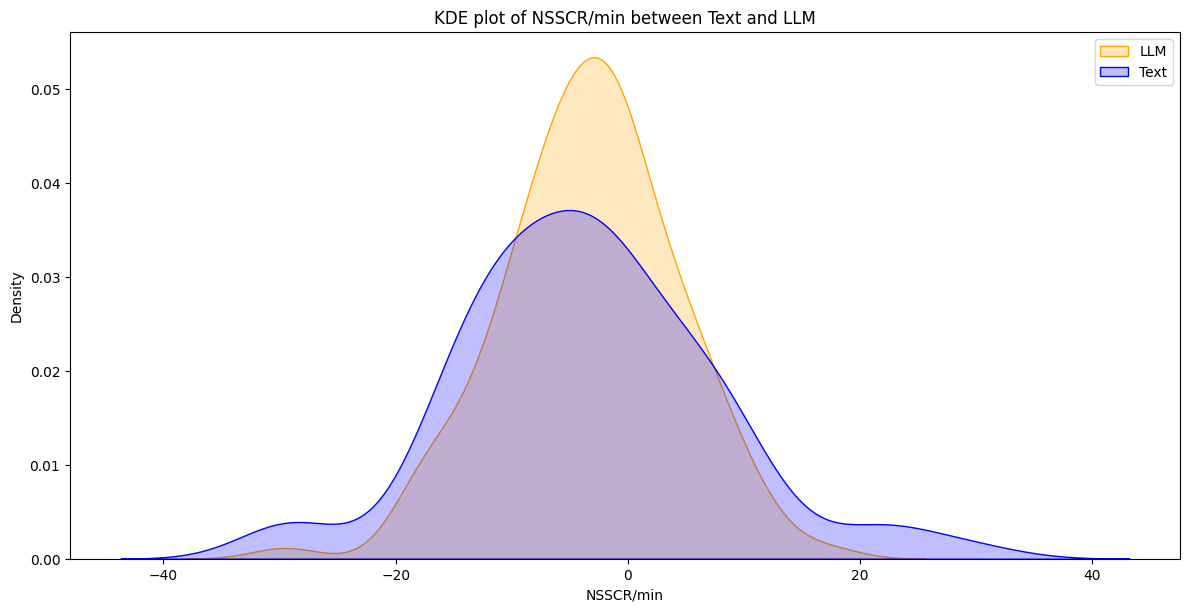

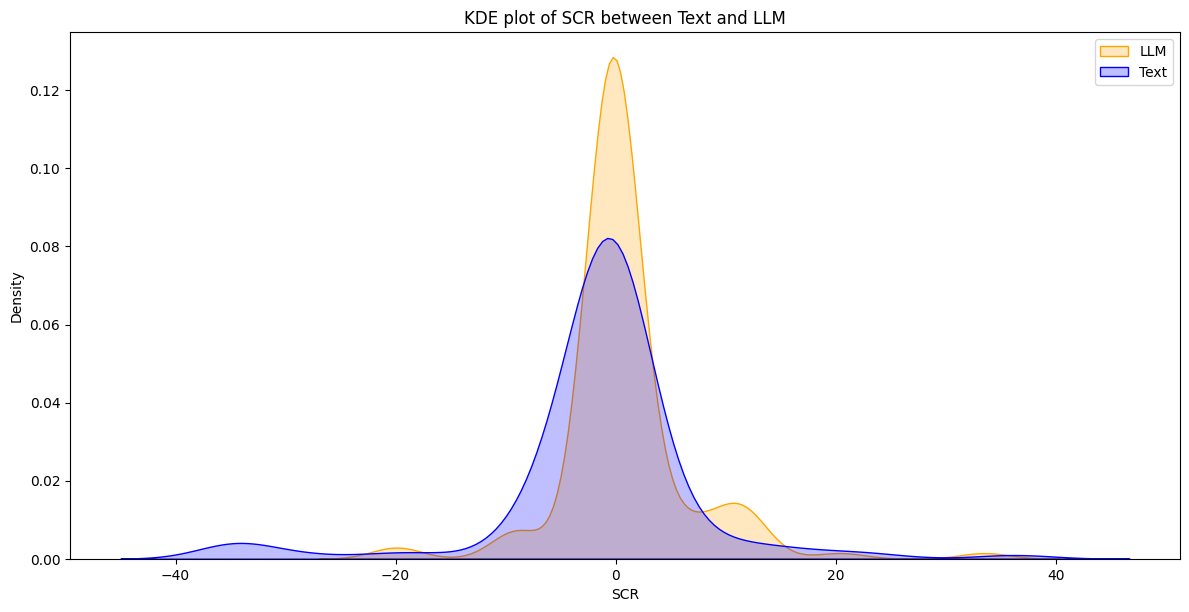

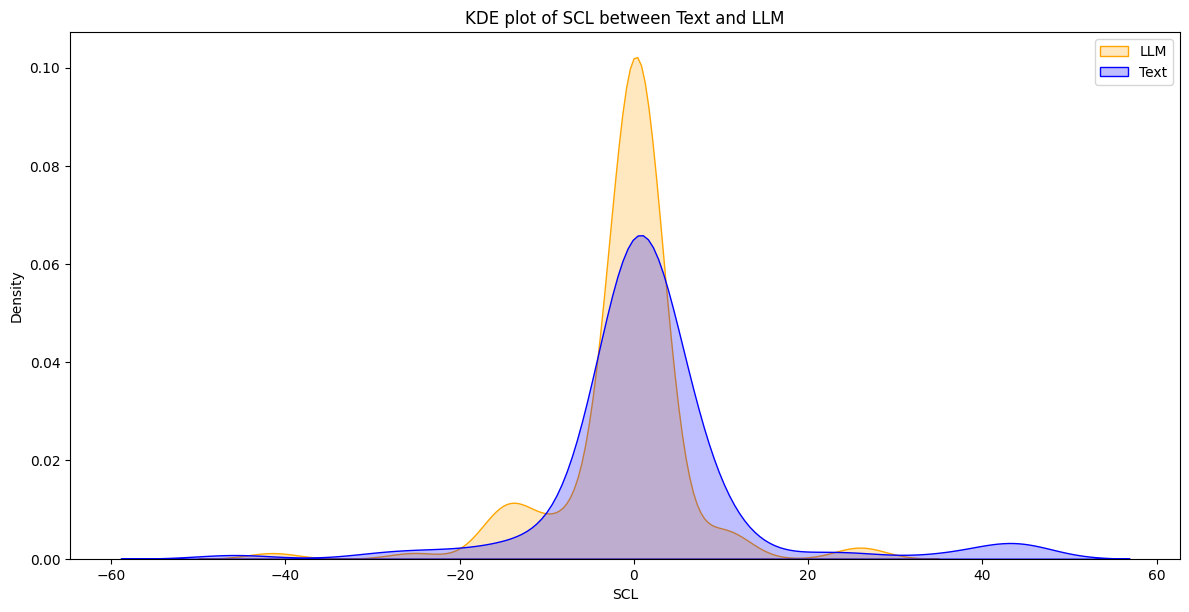

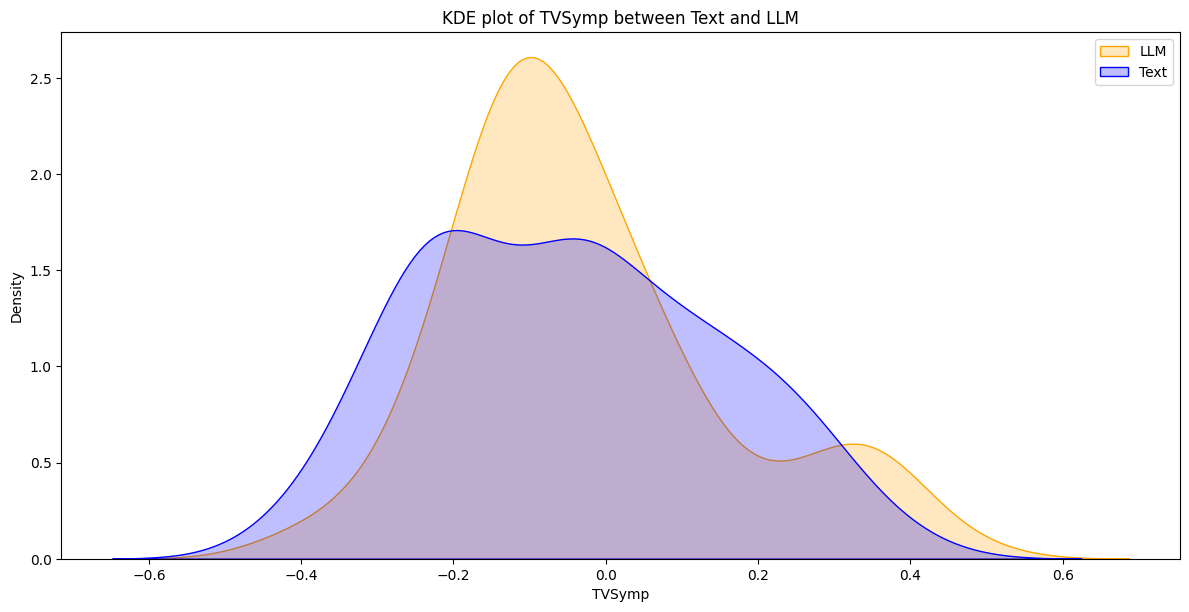

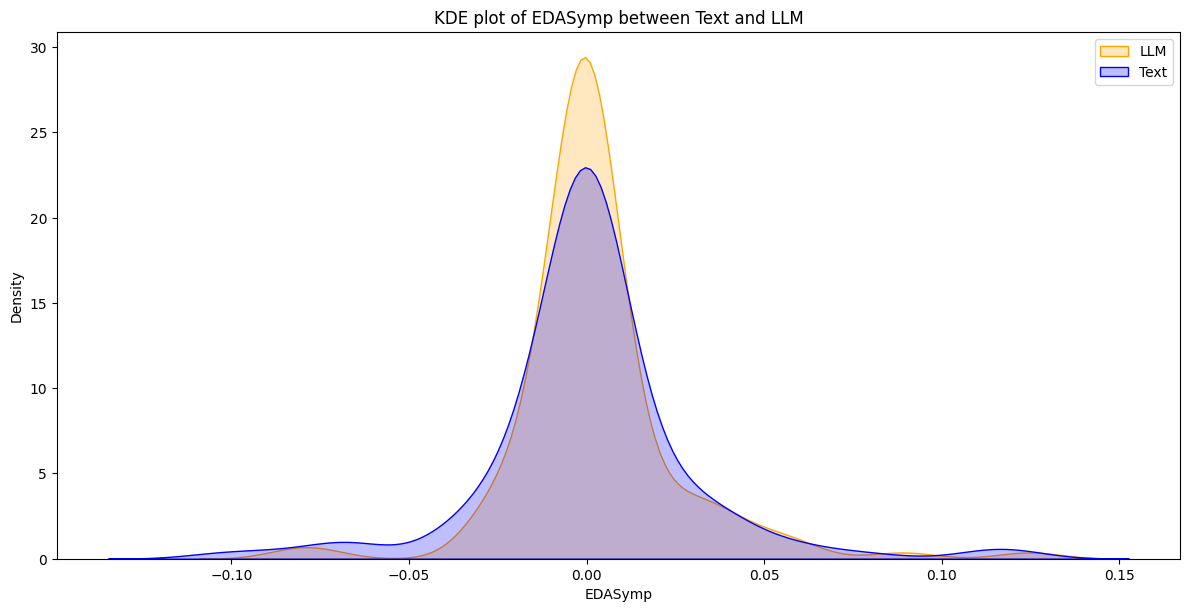

In [4]:
graphdfL = dfwt3.iloc[:,0:5]
graphdfT = dfwt3.iloc[:,6:]
for i in range(5):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(x=graphdfL.iloc[:,i],
            color='orange', label='LLM', fill=True, ax=ax)
    sns.kdeplot(x=graphdfT.iloc[:,i],
            color='blue', label='Text', fill=True, ax=ax)
    ax.legend()
    plt.tight_layout()
    plt.title(f'KDE plot of {names[i]} between Text and LLM')
    ax.set_xlabel(names[i])
    fig.savefig(f'KDE{i}.png',bbox_inches='tight')

In [5]:
rdfwt3 = dfwt3
rdfwt3.columns= range(rdfwt3.shape[1])
with (ro.default_converter + pandas2ri.converter).context():
  r_from_pd_df = ro.conversion.get_conversion().py2rpy(rdfwt3)
ro.r.assign("rd", r_from_pd_df)

for i in range(1, 6):
    ro.r(f"rd[[{i}]] <- as.numeric(rd[[{i}]])")
    ro.r(f"rd[[{i+6}]] <- as.numeric(rd[[{i+6}]])")
ro.r("rd[[6]] <- as.integer(rd[[6]])")
for i in range(1, 6):
    #ro.r(f"result_{i} <- clusWilcox.test(x=rd[[{i}]],y=rd[[{i+6}]], cluster=rd[[6]],paired=TRUE,alternative='l')") #H1: Text>LLM
    ro.r(f"result_{i} <- clusWilcox.test(x=rd[[{i}]],y=rd[[{i+6}]], cluster=rd[[6]],paired=TRUE,alternative='g')") #H1: LLM>Text
    result = ro.r(f"result_{i}")
    print(f"Result for {names[i-1]}:")
    print(result)

Result for NSSCR/min:

	Clustered Wilcoxon signed rank test using Rosner-Glynn-Lee method

data:  [[ and [[; cluster: [[;rd and rd; cluster: rd;1 and 7; cluster: 6;
number of observations: 116;  number of clusters: 23
Z = 0.2478, p-value = 0.4021
alternative hypothesis: true shift in location is greater than 0


Result for SCR:

	Clustered Wilcoxon signed rank test using Rosner-Glynn-Lee method

data:  [[ and [[; cluster: [[;rd and rd; cluster: rd;2 and 8; cluster: 6;
number of observations: 118;  number of clusters: 23
Z = 1.3163, p-value = 0.09404
alternative hypothesis: true shift in location is greater than 0


Result for SCL:

	Clustered Wilcoxon signed rank test using Rosner-Glynn-Lee method

data:  [[ and [[; cluster: [[;rd and rd; cluster: rd;3 and 9; cluster: 6;
number of observations: 118;  number of clusters: 23
Z = -1.3122, p-value = 0.9053
alternative hypothesis: true shift in location is greater than 0


Result for TVSymp:

	Clustered Wilcoxon signed rank test using Rosne

//anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "0". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'int'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
//anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "1". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
//anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "2". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
//anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Er